# DDPM forward and reverse process implementation
Paper: https://arxiv.org/abs/2006.11239

## Forward Process
Fowrad process adss noise to the data


In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
import time
from data.dataset import BEVFeaturesDataset, PaddDataset
from torch.utils.data import DataLoader, Dataset
import wandb
from mmdet.models import HEADS
from mmdet3d.unibev_plugin.models.dense_heads import diffusion_model

os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [2]:
!CUDA_LAUNCH_BLOCKING=1

In [3]:
import math
import torch
from torch import nn
from inspect import isfunction

class UNet(nn.Module):
    def __init__(
        self,
        in_channel=6,
        out_channel=3,
        inner_channel=32,
        norm_groups=32,
        channel_mults=(1, 2, 4, 8, 8),
        attn_res=(8),
        res_blocks=3,
        dropout=0,
        with_noise_level_emb=True,
        image_size=128,
        eps=1e-5
    ):
        super().__init__()

        if with_noise_level_emb:
            noise_level_channel = inner_channel
            self.noise_level_mlp = nn.Sequential(
                PositionalEncoding(inner_channel),
                nn.Linear(inner_channel, inner_channel * 4),
                Swish(),
                nn.Linear(inner_channel * 4, inner_channel)
            )
        else:
            noise_level_channel = None
            self.noise_level_mlp = None
        
        self.image_size = image_size
        self.in_channel = in_channel
        self.out_channel = out_channel

        num_mults = len(channel_mults)
        pre_channel = inner_channel
        feat_channels = [pre_channel]
        now_res = image_size
        downs = [nn.Conv2d(in_channel, inner_channel,
                           kernel_size=3, padding=1)]
        for ind in range(num_mults):
            is_last = (ind == num_mults - 1)
            use_attn = (now_res in attn_res)
            channel_mult = inner_channel * channel_mults[ind]
            for _ in range(0, res_blocks):
                downs.append(ResnetBlocWithAttn(
                    pre_channel, channel_mult, noise_level_emb_dim=noise_level_channel, norm_groups=norm_groups, dropout=dropout, with_attn=use_attn, eps=eps))
                feat_channels.append(channel_mult)
                pre_channel = channel_mult
            if not is_last:
                downs.append(Downsample(pre_channel))
                feat_channels.append(pre_channel)
                now_res = now_res//2
        self.downs = nn.ModuleList(downs)

        self.mid = nn.ModuleList([
            ResnetBlocWithAttn(pre_channel, pre_channel, noise_level_emb_dim=noise_level_channel, norm_groups=norm_groups,
                               dropout=dropout, with_attn=True, eps=eps),
            ResnetBlocWithAttn(pre_channel, pre_channel, noise_level_emb_dim=noise_level_channel, norm_groups=norm_groups,
                               dropout=dropout, with_attn=False, eps=eps)
        ])

        ups = []
        for ind in reversed(range(num_mults)):
            is_last = (ind < 1)
            use_attn = (now_res in attn_res)
            channel_mult = inner_channel * channel_mults[ind]
            for _ in range(0, res_blocks+1):
                ups.append(ResnetBlocWithAttn(
                    pre_channel+feat_channels.pop(), channel_mult, noise_level_emb_dim=noise_level_channel, norm_groups=norm_groups,
                        dropout=dropout, with_attn=use_attn, eps=eps))
                pre_channel = channel_mult
            if not is_last:
                ups.append(Upsample(pre_channel))
                now_res = now_res*2

        self.ups = nn.ModuleList(ups)

        self.final_conv = Block(pre_channel, default(out_channel, in_channel), groups=norm_groups, eps=eps)

    def forward(self, x, time):
        t = self.noise_level_mlp(time) if exists(
            self.noise_level_mlp) else None

        feats = []
        for layer in self.downs:
            if isinstance(layer, ResnetBlocWithAttn):
                x = layer(x, t)
            else:
                x = layer(x)
            feats.append(x)

        for layer in self.mid:
            if isinstance(layer, ResnetBlocWithAttn):
                x = layer(x, t)
            else:
                x = layer(x)

        for layer in self.ups:
            if isinstance(layer, ResnetBlocWithAttn):
                x = layer(torch.cat((x, feats.pop()), dim=1), t)
            else:
                x = layer(x)

        return self.final_conv(x)


# PositionalEncoding Source： https://github.com/lmnt-com/wavegrad/blob/master/src/wavegrad/model.py
class PositionalEncoding(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, noise_level):
        count = self.dim // 2
        step = torch.arange(count, dtype=noise_level.dtype, device=noise_level.device) / count
        encoding = noise_level.unsqueeze(1) * torch.exp(-math.log(1e4) * step.unsqueeze(0))
        encoding = torch.cat([torch.sin(encoding), torch.cos(encoding)], dim=-1)
        return encoding


class FeatureWiseAffine(nn.Module):
    def __init__(self, in_channels, out_channels, use_affine_level=False):
        super(FeatureWiseAffine, self).__init__()
        self.use_affine_level = use_affine_level
        self.noise_func = nn.Sequential(
            nn.Linear(in_channels, out_channels*(1+self.use_affine_level))
        )

    def forward(self, x, noise_embed):
        batch = x.shape[0]
        if self.use_affine_level:
            gamma, beta = self.noise_func(noise_embed).view(batch, -1, 1, 1).chunk(2, dim=1)
            x = (1 + gamma) * x + beta
        else:
            x = x + self.noise_func(noise_embed).view(batch, -1, 1, 1)
        return x


class Swish(nn.Module):
    def forward(self, x):
        return x * torch.sigmoid(x)


class Upsample(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.up = nn.Upsample(scale_factor=2, mode="nearest")
        self.conv = nn.Conv2d(dim, dim, 3, padding=1)

    def forward(self, x):
        return self.conv(self.up(x))


class Downsample(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.conv = nn.Conv2d(dim, dim, 3, 2, 1)

    def forward(self, x):
        return self.conv(x)


# building block modules


class Block(nn.Module):
    def __init__(self, dim, dim_out, groups=32, dropout=0, eps=1e-5):
        super().__init__()
        self.block = nn.Sequential(
            nn.GroupNorm(groups, dim, eps=eps),
            Swish(),
            nn.Dropout(dropout) if dropout != 0 else nn.Identity(),
            nn.Conv2d(dim, dim_out, 3, padding=1)
        )

    def forward(self, x):
        return self.block(x)


class ResnetBlock(nn.Module):
    def __init__(self, dim, dim_out, noise_level_emb_dim=None, dropout=0, use_affine_level=False, norm_groups=32, eps=1e-5):
        super().__init__()
        self.noise_func = FeatureWiseAffine(noise_level_emb_dim, dim_out, use_affine_level)

        self.block1 = Block(dim, dim_out, groups=norm_groups, eps=eps)
        self.block2 = Block(dim_out, dim_out, groups=norm_groups, dropout=dropout, eps=eps)
        self.res_conv = nn.Conv2d(
            dim, dim_out, 1) if dim != dim_out else nn.Identity()

    def forward(self, x, time_emb):
        b, c, h, w = x.shape
        h = self.block1(x)
        h = self.noise_func(h, time_emb)
        h = self.block2(h)
        return h + self.res_conv(x)


class SelfAttention(nn.Module):
    def __init__(self, in_channel, n_head=1, norm_groups=32, eps=1e-5):
        super().__init__()

        self.n_head = n_head

        self.norm = nn.GroupNorm(norm_groups, in_channel, eps=eps)
        self.qkv = nn.Conv2d(in_channel, in_channel * 3, 1, bias=False)
        self.out = nn.Conv2d(in_channel, in_channel, 1)

    def forward(self, input):
        batch, channel, height, width = input.shape
        n_head = self.n_head
        head_dim = channel // n_head

        norm = self.norm(input)
        qkv = self.qkv(norm).view(batch, n_head, head_dim * 3, height, width)
        query, key, value = qkv.chunk(3, dim=2)  # bhdyx

        attn = torch.einsum("bnchw, bncyx -> bnhwyx", query, key).contiguous() / math.sqrt(channel)
        attn = attn.view(batch, n_head, height, width, -1)
        attn = torch.softmax(attn, -1)
        attn = attn.view(batch, n_head, height, width, height, width)

        out = torch.einsum("bnhwyx, bncyx -> bnchw", attn, value).contiguous()
        out = self.out(out.view(batch, channel, height, width))

        return out + input


class ResnetBlocWithAttn(nn.Module):
    def __init__(self, dim, dim_out, *, noise_level_emb_dim=None, norm_groups=32, dropout=0, with_attn=False, eps=1e-5):
        super().__init__()
        self.with_attn = with_attn
        self.res_block = ResnetBlock(
            dim, dim_out, noise_level_emb_dim, norm_groups=norm_groups, dropout=dropout, eps=eps)
        if with_attn:
            self.attn = SelfAttention(dim_out, norm_groups=norm_groups, eps=eps)

    def forward(self, x, time_emb):
        x = self.res_block(x, time_emb)
        if(self.with_attn):
            x = self.attn(x)
        return x


def exists(x):
    return x is not None


def default(val, d):
    if exists(val):
        return val
    return d() if isfunction(d) else d

In [4]:
class RollingStatistics(nn.Module):
    """
    Class for capturing the rolling statistics when doing online training. Calculates the mean and variance of the data per batch and updates the overall mean and variance using https://notmatthancock.github.io/2017/03/23/simple-batch-stat-updates.html formula.

    For online training only do it for one epoch after we have the overall statistics, then we can fix the statistics and do normalization and denormalization using the fixed statistics. This is because the statistics will not change much after one epoch of training, and it will be more stable to use fixed statistics for normalization and denormalization during training.

    Attributes:
        mean: The rolling mean of the data.
        var: The rolling variance of the data.
        std: The rolling standard deviation of the data.
        p_samples: The total number of observations seen so far. Used for calculating the new mean and variance when a new batch of data is observed. p_samples is the amount of samples in a batch.
    """
    def __init__(self, p_samples=0, channels=256):
        super().__init__()
        self.fixed = False
        # self.mean = mean
        # self.var = var
        # self.std = std
        self.p_samples = p_samples
        self.channels = channels

        # register_buffer ensures these move with the model and save in state_dict
        self.register_buffer('mean', torch.zeros(1, channels, 1, 1))
        self.register_buffer('var', torch.ones(1, channels, 1, 1))
        self.register_buffer('std', torch.ones(1, channels, 1, 1))
        # self.register_buffer('p_samples', torch.tensor(0, dtype=torch.long))

    # def set_device(self, device):
    #     if self.mean is not None:
    #         self.mean = self.mean.to(device)
    #     if self.var is not None:
    #         self.var = self.var.to(device)
    #     if self.std is not None:
    #         self.std = self.std.to(device)

    def __str__(self):
        return f"RollingStatistics(mean={torch.mean(self.mean)}, var={torch.mean(self.var)}, std={torch.mean(self.std)}, p_samples={self.p_samples})"

    def update(self, batch_data):
        """
        batch_data shape: (B, C, H, W)
        """
        if self.fixed:
            return

        # Calculate current batch stats
        dims = (0, 2, 3)
        batch_mean = torch.mean(batch_data, dim=dims, keepdim=True)
        batch_var = torch.var(batch_data, dim=dims, keepdim=True, correction=0)
        
        # Calculate q_samples based on ALL elements reduced (B * H * W)
        q_samples = batch_data.shape[0] * batch_data.shape[2] * batch_data.shape[3]

        if self.p_samples == 0:
            self.mean.copy_(batch_mean)
            self.var.copy_(batch_var)
            self.p_samples = q_samples
        else:
            n_p = self.p_samples
            n_q = q_samples
            n_total = n_p + n_q

            # Welford's Parallel Mean
            new_mean = (n_p * self.mean + n_q * batch_mean) / n_total

            # Welford's Parallel Variance
            # Formula: [(n_p * var_p + n_q * var_q) / n_total] + [n_p * n_q * (mean_p - mean_q)^2 / n_total^2]
            mean_diff = self.mean - batch_mean
            new_var = ((n_p * self.var + n_q * batch_var) / n_total) + \
                      ((n_p * n_q) * torch.pow(mean_diff, 2) / (n_total ** 2))

            self.mean.copy_(new_mean)
            self.var.copy_(new_var)
            self.p_samples = n_total

        self.std.copy_(torch.sqrt(self.var + 1e-8))

    def normalize(self, sample):
        return (sample - self.mean) / self.std

    def denormalize(self, sample):
        return (sample * self.std) + self.mean

    def get_stats(self):
        return {'mean': self.mean, 'var': self.var, 'std': self.std, 'p_samples': self.p_samples, 'channels': self.channels}
    

    # def normalize(self, sample):
    #     if self.mean is None or self.std is None:
    #         raise ValueError("Rolling statistics have not been updated with any data yet.")
    #     return (sample - self.mean) / (self.std + 1e-8)
    
    # def denormalize(self, sample):
    #     if self.mean is None or self.std is None:
    #         raise ValueError("Rolling statistics have not been updated with any data yet.")
    #     return sample * (self.std + 1e-8) + self.mean

In [10]:
from numpy import mean, var
from functools import partial


def _warmup_beta(linear_start, linear_end, n_timestep, warmup_frac):
    betas = linear_end * np.ones(n_timestep, dtype=np.float64)
    warmup_time = int(n_timestep * warmup_frac)
    betas[:warmup_time] = np.linspace(
        linear_start, linear_end, warmup_time, dtype=np.float64)
    return betas

def make_beta_schedule(schedule, n_timestep, linear_start=1e-6, linear_end=1e-2, cosine_s=8e-3):
    """
    Create a beta schedule that is a function of the number of diffusion steps.
    Return:
        betas: a numpy array of shape (n_timestep,) that defines the beta schedule
    """
    if schedule == 'quad':
        betas = np.linspace(linear_start ** 0.5, linear_end ** 0.5,
                            n_timestep) ** 2
    elif schedule == 'linear':
        betas = np.linspace(linear_start, linear_end,
                            n_timestep)
    elif schedule == 'warmup10':
        betas = _warmup_beta(linear_start, linear_end,
                             n_timestep, 0.1)
    elif schedule == 'warmup50':
        betas = _warmup_beta(linear_start, linear_end,
                             n_timestep, 0.5)
    elif schedule == 'const':
        betas = linear_end * np.ones(n_timestep, dtype=np.float64)
    elif schedule == 'jsd':  # 1/T, 1/(T-1), 1/(T-2), ..., 1
        betas = 1. / np.linspace(n_timestep,
                                 1, n_timestep, dtype=np.float64)
    elif schedule == "cosine":
        timesteps = (
            torch.arange(n_timestep + 1, dtype=torch.float64) /
            n_timestep + cosine_s
        )
        alphas = timesteps / (1 + cosine_s) * math.pi / 2
        alphas = torch.cos(alphas).pow(2)
        alphas = alphas / alphas[0]
        betas = 1 - alphas[1:] / alphas[:-1]
        betas = betas.clamp(max=0.999)
    else:
        raise NotImplementedError(schedule)
    return torch.from_numpy(betas) if type(betas) == np.ndarray else betas


class DenoiseDiffusion(nn.Module):
    def __init__(self, model_config, beta_schedule, loss_fn=nn.L1Loss()):
        super().__init__()
        # Parameters for training
        self.loss_fn = loss_fn
        self.eps_model = UNet(**model_config)
        self.beta_schedule = beta_schedule

        self.rolling_stats_img = RollingStatistics(channels=model_config['out_channel'])
        self.rolling_stats_pts = RollingStatistics(channels=model_config['out_channel'])

        # Parameters for diffusion process
        self.set_new_noise_schedule()         

    def set_new_noise_schedule(self, device=torch.device('cuda'), phase='train'):
        self.n_steps = self.beta_schedule[phase]['n_timestep']
        to_torch = partial(torch.as_tensor, dtype=torch.float32, device=device)

        betas = make_beta_schedule(**self.beta_schedule[phase])
        # self.betas = beta.type(dtype=torch.float32).to(self.eps_model.device)
        alphas = 1. - betas
        gammas = torch.cumprod(alphas, dim=0)
        sigmas = torch.sqrt(1.0 - gammas) # alpha_t in dpm-solver is gammas
        lambdas = torch.log(alphas / sigmas)

        self.register_buffer("betas", to_torch(betas))
        self.register_buffer("alphas", to_torch(alphas))
        self.register_buffer("gammas", to_torch(gammas))
        self.register_buffer("sigmas", to_torch(sigmas))
        self.register_buffer("lambdas", to_torch(lambdas))

    def save_output_img(self, bev_consumer_prediction, pts_bev_embed, epoch):
        save_dir = '/home/mingdayang/mmdetection3d/figures/diffusion_output_imgs/'
        os.makedirs(save_dir, exist_ok=True)
        bev_consumer_prediction = bev_consumer_prediction.cpu().numpy()
        pts_bev_embed = pts_bev_embed.cpu().numpy()
        # pts_bev_embed = rearrange(pts_bev_embed, 'b (h w) c -> b c h w', h=200, w=200).cpu().numpy()
        fig, ax = plt.subplots(1, 2, figsize=(10, 5))
        im0 = ax[0].imshow(bev_consumer_prediction[0, 0], cmap='viridis')
        ax[0].set_title('Prediction')
        im1 = ax[1].imshow(pts_bev_embed[0, 0], cmap='viridis')
        ax[1].set_title('Ground Truth')

        fig.colorbar(im0, ax=ax[0])
        fig.colorbar(im1, ax=ax[1]) 
        
        plt.savefig(os.path.join(save_dir, f'diffusion_output{epoch}.png'))
        plt.close(fig)

    def gather(self, tensor, t):
        """
        Gather the values of x at the time steps t.
        Makes it compatible with the shape of x0, which is (B, C, H, W).
        Args:
            tensor: a tensor of shape (n_steps,)
            t: a tensor of shape (B,)
        Return:
            a tensor of shape (B, 1, 1, 1) that contains the values of x at the time steps t
        """
        t = tensor.gather(-1, t)
        return t.reshape(-1, 1, 1, 1)
    
        # We need a function that samples the batch 
    def q_sample(self, y0, sample_gammas, noise=None):
        """
        Sample from q(yt|y0), reading same as sample xt at step t given x0.
        Other implementations also use function q_xt_x0 first but we can directly implement it here.
        Args:
            y0: the original data, shape (B, C, H, W)
            sample_gammas: the gamma values for sampling, shape (B,)
            noise: the noise, shape (B, C, H, W)
        Return:
            yt: the noisy data at time step t, shape (B, C, H, W)
        """
        eps = torch.randn_like(y0, device=y0.device) if noise is None else noise
        
        return (
            torch.sqrt(sample_gammas) * y0 + torch.sqrt(1 - sample_gammas) * eps
        )
    

    def forward(self, y0, y_cond=None):
        """
        Algorithm 1 in Denoising Diffusion Probalisitic Models

        Args:
            y0: the original data, shape (B, C, H, W)
        """
        b, *_ = y0.shape

        t = torch.randint(1, self.n_steps, (b,), device=y0.device, dtype=torch.long)
        # Select a random gamma for each sample in the batch, which is between gamma_t and gamma_t-1 of generated timesteps t. This is to make the training more stable and avoid overfitting to specific timesteps.
        gamma_t1 = self.gather(self.gammas, t - 1)
        gamma_t2 = self.gather(self.gammas, t)
        sample_gammas = (gamma_t2 - gamma_t1) * torch.rand((b, 1, 1, 1), device=y0.device) + gamma_t1
        sample_gammas = sample_gammas

        # Create the noise to compare it to the predicted noise, which is used for training the model. This is the noise added to the original data to get the noisy data at time step t.
        noise = torch.randn_like(y0, device=y0.device)
        y_noisy = self.q_sample(y0, sample_gammas, noise=noise)

        noise_hat = self.eps_model(torch.cat([y_noisy, y_cond], dim=1) if y_cond is not None else y_noisy, sample_gammas)

        loss = self.loss_fn(noise_hat, noise)
        return loss
    

    @torch.no_grad()
    def ddpm_sampler(self, y_cond=None, noise=None, sample_inter=10, clip_denoised=True):
        """
        https://arxiv.org/pdf/2006.11239
        Implementation of algorithm 2. However, to keep sampling stable we calculate the start from noise, clamp it and use the posterior of equation 7 to calculate y_t-1.
        We use equation 15 to calculate y_0 (start from noise), then clamp it. Then we use equation 7 to calculate y_t-1 = mean + sigma * z
        """
        y = torch.randn_like(y_cond, device=y_cond.device) if noise is None else noise
        ret_arr = y.clone()
        for i in tqdm(reversed(range(self.n_steps)), desc='DDPM sampler', total=self.n_steps):
            z = torch.randn_like(y) if i > 1 else torch.zeros_like(y)   
            t_tensor = torch.full((y_cond.shape[0],), i, device=y_cond.device, dtype=torch.long)

            gamma_t = self.gather(self.gammas, t_tensor)
            gamma_t_prev = self.gather(self.gammas, t_tensor - 1) if i > 0 else torch.ones_like(gamma_t)
            beta_t = self.gather(self.betas, t_tensor)
            alpha_t = self.gather(self.alphas, t_tensor)

            y_0_tilde = (y - torch.sqrt(1-gamma_t)*self.eps_model(torch.cat([y, y_cond], dim=1) if y_cond is not None else y, gamma_t)) / torch.sqrt(gamma_t) # predict start

            if clip_denoised:
                y_0_tilde = torch.clamp(y_0_tilde, -3., 3.)

            # eta = (y - torch.sqrt(alpha_t)*y_0_tilde) / torch.sqrt(1-alpha_t)

            # Calculate posterior mean and variance
            mean = (torch.sqrt(gamma_t_prev) * beta_t * y_0_tilde) / (1 - gamma_t) + (torch.sqrt(alpha_t) * (1 - gamma_t_prev) * y) / (1 - gamma_t)

            sigma = (1 - gamma_t_prev) * beta_t / (1 - gamma_t)

            y = mean + sigma * z

            if i % sample_inter == 0:
                ret_arr = torch.cat((ret_arr, y), dim=0)

        return y, ret_arr
    

    @torch.no_grad()
    def ddim_sampler(self, y_cond=None, noise=None, sample_inter=1, steps=50, clip_denoised=True, eta=0.0):
        """
        DDIM sampler from https://arxiv.org/abs/2010.02502
        With eta=0, it becomes a deterministic sampler, which is the one we will use in this implementation. With eta>0, it becomes a stochastic sampler, which is similar to the DDPM sampler but with different noise scale. 
        """
        y = torch.randn_like(y_cond, device=y_cond.device) if noise is None else noise
        ret_arr = y.clone()
        step_size = self.n_steps // steps
        time_steps = np.asarray(list(range(0, self.n_steps, step_size)))
        time_steps_prev = np.concatenate(([0], time_steps[:-1]))
        print(time_steps)
        for i in tqdm(reversed(range(0, steps)), desc='DDIM sampling loop timestep', total=steps):
            # t = self.n_steps - i * step_size
            # t = max(t, 1)  # Ensure t does not go below 1
            # print(i)
            t_tensor = torch.full((y_cond.shape[0],), time_steps[i], dtype=torch.long, device=y_cond.device)
            # print(t_tensor)
            t_tensor_prev = torch.full((y_cond.shape[0],), time_steps_prev[i], dtype=torch.long, device=y_cond.device)
            # print(t_tensor_prev)
            gamma = self.gather(self.gammas, t_tensor)
            
            # Make sure that when t_tensor - step_size - 1 is negative, we use gamma_prev = 1, which means that we are at the final step and we should not add any noise.
            gamma_prev = self.gather(self.gammas, torch.clamp(t_tensor_prev, min=0)) # if (t_tensor_prev >= 0).any() else torch.ones_like(gamma)
            
            noise_pred = self.eps_model(torch.cat([y, y_cond], dim=1) if y_cond is not None else y, gamma)

            y0_pred = (y - torch.sqrt(1 - gamma) * noise_pred) / torch.sqrt(gamma)
            
            # Clamp prediction to stablize sampling
            if clip_denoised:
                y0_pred = torch.clamp(y0_pred, -3., 3.)

            sigma_t = eta * torch.sqrt((1 - gamma_prev) / (1 - gamma)) * torch.sqrt(1-gamma / gamma_prev)

            dir_yt = torch.sqrt(1 - gamma_prev - torch.pow(sigma_t, 2)) * noise_pred
            
            
            y = torch.sqrt(gamma_prev) * y0_pred + dir_yt + sigma_t * torch.randn_like(y)

            if i % sample_inter == 0:
                ret_arr = torch.cat((ret_arr, y), dim=0)

        return y, ret_arr
    

    @torch.no_grad()
    def dpm_solver_multi_step_sampler(self, y_cond=None, noise=None, sample_inter=10, steps=10, clip_denoised=True):
        """
        Implement multistep from https://arxiv.org/pdf/2211.01095
        """
        step_size = self.n_steps // steps


        yT = torch.randn_like(y_cond, device=y_cond.device) if noise is None else noise
        ret_arr = yT.clone()

        ytilde = yT


        t_0 = torch.full((y_cond.shape[0],), self.n_steps - 1, device=y_cond.device, dtype=torch.long)
        t_1 = torch.full((y_cond.shape[0],), self.n_steps - step_size - 1, device=y_cond.device, dtype=torch.long)
        t_2 = torch.full((y_cond.shape[0],), self.n_steps - 2 * step_size - 1, device=y_cond.device, dtype=torch.long)
        # print(self.lambdas.shape)
        # print(t_1)
        # print(t_0)
        h_i_prev = self.gather(self.lambdas, t_1) - self.gather(self.lambdas, t_0)

        # Buffer P and Q for multi_step sampling. P = -2 and Q = -1 in timestepe space, which means that they are the data prediction at t_i-2 and t_i-1 respectively. We will update them in each step and use them to calculate the data prediction at t_i.
        P = self.data_prediction(ytilde, y_cond=y_cond, t=t_0) # y_theta_0
        if clip_denoised:
            P = torch.clamp(P, -3., 3.)
        y_tilde = (self.gather(self.sigmas, t_1)/self.gather(self.sigmas, t_0)) * ytilde - self.gather(self.alphas, t_1) * (torch.exp(-h_i_prev) - 1) * P
        Q = self.data_prediction(y_tilde, y_cond=y_cond, t=t_1) # y_theta_2
        if clip_denoised:
            Q = torch.clamp(Q, -3., 3.)
        

        for i in tqdm((range(2, steps)), desc='DPM-Solver++(2M) sampler', initial=2, total=steps):
            t_cur = self.n_steps - i * step_size - 1
            t_prev = self.n_steps - (i - 1) * step_size - 1

            t_prev_tensor = torch.full((y_cond.shape[0],), t_prev, device=y_cond.device, dtype=torch.long)
            t_cur_tensor = torch.full((y_cond.shape[0],), t_cur, device=y_cond.device, dtype=torch.long)

            h_i_cur = self.gather(self.lambdas, t_cur_tensor) - self.gather(self.lambdas, t_prev_tensor)
            r_i = h_i_prev / h_i_cur

            D_i = (1 + 1 / (2 * r_i)) * Q - 1 / (2 * r_i) * P

            y_tilde = (self.gather(self.sigmas, t_cur_tensor) / self.gather(self.sigmas, t_prev_tensor)) * y_tilde - self.gather(self.alphas, t_cur_tensor) * (torch.exp(-h_i_cur) - 1) * D_i
            
            h_i_prev = h_i_cur
            P = Q.clone()
            if i < self.n_steps:
                Q = self.data_prediction(y_tilde, y_cond=y_cond, t=t_cur_tensor)
                if clip_denoised:
                    Q = torch.clamp(Q, -3., 3.)

            if i % sample_inter == 0:
                ret_arr = torch.cat((ret_arr, y_tilde), dim=0)

        return y_tilde, ret_arr
    
    def data_prediction(self, yt, y_cond=None, t=None):
        gamma = self.gather(self.gammas, t).to(yt.device)
        noise_pred = self.eps_model(torch.cat([yt, y_cond], dim=1) if y_cond is not None else yt, gamma)
        y0_hat = (yt - torch.sqrt(1 - gamma) * noise_pred) / torch.sqrt(gamma)

        return y0_hat

In [11]:
beta_schedule = dict(
    train=dict(
        schedule='linear',
        n_timestep=2000,
        linear_start=1e-4,
        linear_end=2e-2,
    ),
    test=dict(
        schedule='linear',
        n_timestep=1000,
        linear_start=1e-5,
        linear_end=1e-1,
    )
)

model_config = dict(
    in_channel=2,
    out_channel=1,
    inner_channel=64,
    norm_groups=32,
    channel_mults=(1, 2, 4, 8),
    attn_res=(25,),
    res_blocks=2,
    dropout=0,
    with_noise_level_emb=True,
    image_size=200,
    eps=1e-5
)

hyperparameters = dict(
    model_config=model_config,
    beta_schedule=beta_schedule,
    batch_size=12,
)

diffusion = DenoiseDiffusion(model_config=model_config, beta_schedule=beta_schedule)
# ModelClass = HEADS.get('DenoiseDiffusion')
# diffusion = ModelClass(model_config=model_config, beta_schedule=beta_schedule)
diffusion.set_new_noise_schedule(phase='train')

In [9]:
diffusion.to('cuda')
out, _ = diffusion.ddim_sampler(y_cond=torch.randn(1, 1, 200, 200, device='cuda'), steps=26)

[   0   76  152  228  304  380  456  532  608  684  760  836  912  988
 1064 1140 1216 1292 1368 1444 1520 1596 1672 1748 1824 1900 1976]


DDIM sampling loop timestep:   8%|▊         | 2/26 [00:00<00:01, 15.72it/s]

25
tensor([1900], device='cuda:0')
tensor([1824], device='cuda:0')
24
tensor([1824], device='cuda:0')
tensor([1748], device='cuda:0')
23
tensor([1748], device='cuda:0')
tensor([1672], device='cuda:0')
22
tensor([1672], device='cuda:0')
tensor([1596], device='cuda:0')


DDIM sampling loop timestep:  23%|██▎       | 6/26 [00:00<00:01, 17.40it/s]

21
tensor([1596], device='cuda:0')
tensor([1520], device='cuda:0')
20
tensor([1520], device='cuda:0')
tensor([1444], device='cuda:0')
19
tensor([1444], device='cuda:0')
tensor([1368], device='cuda:0')
18
tensor([1368], device='cuda:0')
tensor([1292], device='cuda:0')


DDIM sampling loop timestep:  38%|███▊      | 10/26 [00:00<00:00, 17.91it/s]

17
tensor([1292], device='cuda:0')
tensor([1216], device='cuda:0')
16
tensor([1216], device='cuda:0')
tensor([1140], device='cuda:0')
15
tensor([1140], device='cuda:0')
tensor([1064], device='cuda:0')
14
tensor([1064], device='cuda:0')
tensor([988], device='cuda:0')


DDIM sampling loop timestep:  54%|█████▍    | 14/26 [00:00<00:00, 18.70it/s]

13
tensor([988], device='cuda:0')
tensor([912], device='cuda:0')
12
tensor([912], device='cuda:0')
tensor([836], device='cuda:0')
11
tensor([836], device='cuda:0')
tensor([760], device='cuda:0')
10
tensor([760], device='cuda:0')
tensor([684], device='cuda:0')


DDIM sampling loop timestep:  69%|██████▉   | 18/26 [00:00<00:00, 19.05it/s]

9
tensor([684], device='cuda:0')
tensor([608], device='cuda:0')
8
tensor([608], device='cuda:0')
tensor([532], device='cuda:0')
7
tensor([532], device='cuda:0')
tensor([456], device='cuda:0')
6
tensor([456], device='cuda:0')
tensor([380], device='cuda:0')


DDIM sampling loop timestep:  85%|████████▍ | 22/26 [00:01<00:00, 19.24it/s]

5
tensor([380], device='cuda:0')
tensor([304], device='cuda:0')
4
tensor([304], device='cuda:0')
tensor([228], device='cuda:0')
3
tensor([228], device='cuda:0')
tensor([152], device='cuda:0')
2
tensor([152], device='cuda:0')
tensor([76], device='cuda:0')


DDIM sampling loop timestep: 100%|██████████| 26/26 [00:01<00:00, 18.61it/s]

1
tensor([76], device='cuda:0')
tensor([0], device='cuda:0')
0
tensor([0], device='cuda:0')
tensor([0], device='cuda:0')


In [29]:
from torchinfo import summary

summary(Unet, input_size=[(hyperparameters['batch_size'], model_config['in_channel'], model_config['image_size'], model_config['image_size']), (hyperparameters['batch_size'], 1)])

Layer (type:depth-idx)                             Output Shape              Param #
UNet                                               [24, 3, 200, 200]         --
├─Sequential: 1-1                                  [24, 1, 64]               --
│    └─PositionalEncoding: 2-1                     [24, 1, 64]               --
│    └─Linear: 2-2                                 [24, 1, 256]              16,640
│    └─Swish: 2-3                                  [24, 1, 256]              --
│    └─Linear: 2-4                                 [24, 1, 64]               16,448
├─ModuleList: 1-2                                  --                        --
│    └─Conv2d: 2-5                                 [24, 64, 200, 200]        3,520
│    └─ResnetBlocWithAttn: 2-6                     [24, 64, 200, 200]        --
│    │    └─ResnetBlock: 3-1                       [24, 64, 200, 200]        78,272
│    └─ResnetBlocWithAttn: 2-7                     [24, 64, 200, 200]        --
│    │    └─ResnetBl

In [10]:
size = 64
square_size = 16
tensor = torch.zeros(1, 1, size, size)
start = (size - square_size) // 2
end = start + square_size
tensor[:, :, start:end, start:end] = 1.0

samples = tensor.repeat(100, 1, 1, 1)

DPM-Solver++(2M) sampler: 100%|██████████| 50/50 [00:05<00:00,  9.29it/s]


tensor([[[[ 0.7493,  0.8052,  1.1039,  ..., -1.0800,  0.9338,  0.9311],
          [ 1.0656, -1.1639, -0.8349,  ...,  0.8830, -0.8716, -0.9343],
          [ 0.9393, -0.9565,  0.7126,  ..., -0.9689, -1.0667, -0.9978],
          ...,
          [ 1.0381,  0.7718, -0.7908,  ..., -0.7216, -0.8418,  0.8781],
          [ 1.0738,  0.9223, -1.0642,  ..., -0.8302,  0.9578,  1.0645],
          [ 1.0373, -0.9970,  0.9709,  ..., -1.1273, -1.0922,  0.9339]],

         [[ 0.9545, -0.8910,  0.7801,  ...,  0.6400,  0.9607,  0.9212],
          [ 0.7561,  0.8856,  1.1205,  ...,  0.7652, -0.9901,  0.9785],
          [ 0.9532,  1.0438,  1.0003,  ..., -1.0989,  0.9439,  1.0853],
          ...,
          [ 1.2111, -0.7978,  0.6923,  ..., -0.8911,  1.0367, -0.7059],
          [-0.9602,  1.0273,  0.8869,  ..., -1.2225, -0.9859, -0.9065],
          [-1.0353,  0.8790, -0.9530,  ...,  0.9529, -0.7953,  1.1069]],

         [[ 0.9304, -0.7513, -1.1054,  ...,  0.8611,  1.0137, -0.9496],
          [-0.7191, -0.9161, -

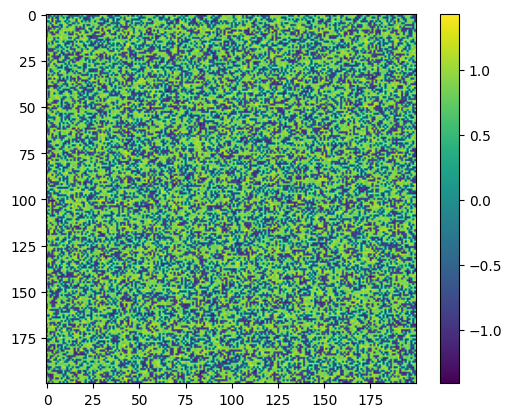

In [21]:
diffusion.set_new_noise_schedule(phase='test')
diffusion.to('cuda')
sampled = diffusion.dpm_solver_multi_step_sampler(y_cond=torch.randn(1, 3, 200, 200, device='cuda'), steps=50, clip_denoised=True)
y, ret_arr = sampled
print(y)
print(f"Max: {torch.amax(y)}, Min: {torch.amin(y)}")
plt.imshow(y.cpu().numpy()[0, 0], cmap='viridis')
plt.colorbar()

In [15]:
from torch.utils.data import DataLoader, Subset

def load_data():
    # Load the saved data
    dataset = BEVFeaturesDataset(root_dir='/home/mingdayang/FeatureBridgeMapping/data/bev_features', transform=None)

    return dataset

def create_splits(dataset, train_split=0.8):
    train_dataset, test_dataset = torch.utils.data.random_split(dataset, [int(train_split * len(dataset)), len(dataset) - int(train_split * len(dataset))])

    return train_dataset, test_dataset

def make_loader(batch_size, dataset):

    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
        # Let's check out what we've created

    return dataloader

dataset = load_data()
train_dataset, test_dataset = create_splits(dataset)
train_loader = make_loader(hyperparameters['batch_size'], train_dataset)
test_loader = make_loader(hyperparameters['batch_size'], test_dataset)
single_loader = DataLoader(Subset(dataset, [0]), batch_size=hyperparameters['batch_size'], shuffle=False)


Img max: 1.3804692029953003, min: -1.6715118885040283
Pts max: 0.40529027581214905, min: -0.3783085346221924
tensor(1.3805)
Normalized img max: 1.3804692029953003, min: -1.6715118885040283
Normalized pts max: 0.40529027581214905, min: -0.3783085346221924


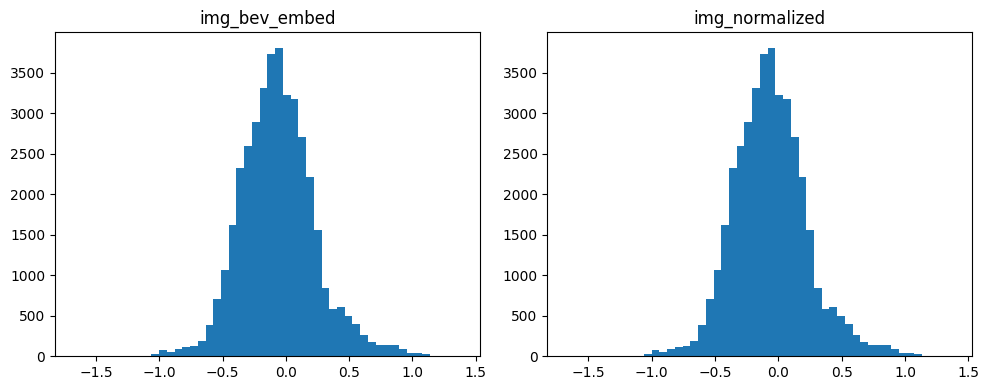

In [22]:
sample = next(iter(single_loader))
print(f"Img max: {torch.amax(sample['img_bev_embed'])}, min: {torch.amin(sample['img_bev_embed'])}")
print(f"Pts max: {torch.amax(sample['pts_bev_embed'])}, min: {torch.amin(sample['pts_bev_embed'])}")
print(torch.amax(sample['img_bev_embed']))

# diffusion.rolling_stats_img.update(sample['img_bev_embed'])
# diffusion.rolling_stats_pts.update(sample['pts_bev_embed'])

img_normalized = diffusion.rolling_stats_img.normalize(sample['img_bev_embed'])
pts_normalized = diffusion.rolling_stats_pts.normalize(sample['pts_bev_embed'])
print(f"Normalized img max: {torch.amax(img_normalized)}, min: {torch.amin(img_normalized)}")
print(f"Normalized pts max: {torch.amax(pts_normalized)}, min: {torch.amin(pts_normalized)}")

fig, ax = plt.subplots(1, 2, figsize=(10, 4))

ax[0].hist(sample['img_bev_embed'].cpu().numpy().ravel(), bins=50)
ax[0].set_title('img_bev_embed')

ax[1].hist(img_normalized.cpu().numpy().ravel(), bins=50)
ax[1].set_title('img_normalized')

plt.tight_layout()
plt.show()


In [23]:
# simple training loop using the existing `tensor` as toy data
device = 'cuda'
diffusion.to(device)
diffusion.eps_model.train()

optimizer = torch.optim.Adam(diffusion.eps_model.parameters(), lr=1e-4)

epochs = 10000
val_interval = 10

try:
    with wandb.init(project="diffusion_test", config=hyperparameters) as run:
        run.watch(diffusion, log="all", log_freq=10)
        for epoch in range(epochs):
            diffusion.set_new_noise_schedule(phase='train')
            train_loss = 0
            for batch in tqdm(single_loader, desc=f'Epoch {epoch+1}/{epochs}'):
                X, y = batch['img_bev_embed'], batch['pts_bev_embed']
                X = X.to(device)
                y = y.to(device)
                if epoch > 1:
                    diffusion.rolling_stats_img.fixed = True
                    diffusion.rolling_stats_pts.fixed = True
                
                diffusion.rolling_stats_img.update(X)
                diffusion.rolling_stats_pts.update(y)

                X = diffusion.rolling_stats_img.normalize(X)
                y = diffusion.rolling_stats_pts.normalize(y)

                print(f"Rolling stats img: {diffusion.rolling_stats_img}")
                print(f"Rolling stats pts: {diffusion.rolling_stats_pts}")
                
                print(f"X min max: {torch.amin(X)}, {torch.amax(X)}")
                print(f'y min max: {torch.amin(y)}, {torch.amax(y)}')
                
                loss = diffusion.forward(y0=y, y_cond=X)
                nn.utils.clip_grad_norm_(diffusion.eps_model.parameters(), max_norm=5.0)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                train_loss += loss.item()
                print(f"Batch Loss: {loss.item()}")
            
            avg_train_loss = train_loss / len(single_loader)
            run.log({'train_loss': avg_train_loss}, step=epoch)
            if avg_train_loss < 0.01:
                print(f"Early stopping at epoch {epoch+1} with average training loss {avg_train_loss}")
                break

        run.finish()
except (BrokenPipeError, KeyboardInterrupt) as e:
    print(f"Training interrupted: {e}")
    wandb.finish()
finally:
    wandb.finish()


In [25]:
def save_model(model, model_config, beta_schedule):
    save_temp = {}
    model.to('cpu')
    save_temp['model_state_dict'] = model.eps_model.state_dict()
    save_temp['model_config'] = model_config
    save_temp['beta_schedule'] = beta_schedule
    save_temp['rolling_stats_img'] = model.rolling_stats_img.get_stats()
    save_temp['rolling_stats_pts'] = model.rolling_stats_pts.get_stats()
    torch.save(save_temp, 'checkpoints/temp_single_channel_single_sample_normalized.pth')

save_model(diffusion, model_config, beta_schedule)

In [13]:
checkpoint = torch.load('/home/mingdayang/FeatureBridgeMapping/checkpoints/temp_single_channel_single_sample_normalized.pth')
diffusion = DenoiseDiffusion(checkpoint['model_config'], checkpoint['beta_schedule'], 'cuda:0')
diffusion.eps_model.load_state_dict(checkpoint['model_state_dict'])
diffusion.rolling_stats_img.mean.copy_(checkpoint['rolling_stats_img']['mean'])
diffusion.rolling_stats_img.var.copy_(checkpoint['rolling_stats_img']['var'])
diffusion.rolling_stats_img.std.copy_(checkpoint['rolling_stats_img']['std'])
diffusion.rolling_stats_img.p_samples = checkpoint['rolling_stats_img']['p_samples']
diffusion.rolling_stats_pts.mean.copy_(checkpoint['rolling_stats_pts']['mean'])
diffusion.rolling_stats_pts.var.copy_(checkpoint['rolling_stats_pts']['var'])
diffusion.rolling_stats_pts.std.copy_(checkpoint['rolling_stats_pts']['std'])
diffusion.rolling_stats_pts.p_samples = checkpoint['rolling_stats_pts']['p_samples']

diffusion.set_new_noise_schedule(phase='train')
diffusion.to('cuda')
print(diffusion.eps_model.in_channel)

2


In [16]:
torch.manual_seed(70)
noise = torch.randn(1, 1, 200, 200, device='cuda')
sample = single_loader.dataset[0]['img_bev_embed'].to('cuda').unsqueeze(0)
sample = diffusion.rolling_stats_img.normalize(sample)

DDPM sampler: 100%|██████████| 1000/1000 [00:53<00:00, 18.73it/s]


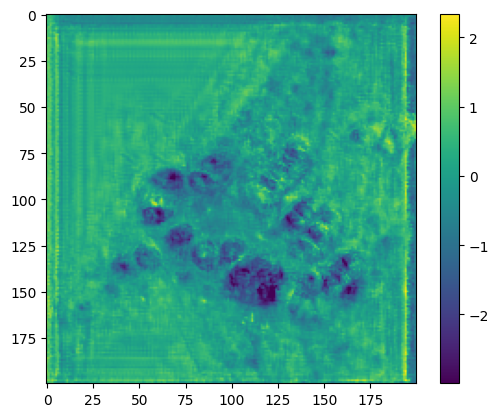

In [53]:
y_ddpm, ret_arr_dpm = diffusion.ddpm_sampler(y_cond=sample, noise=noise, sample_inter=10, clip_denoised=True)
plt.imshow(y_ddpm.cpu().numpy()[0, 0], cmap='viridis')
plt.colorbar()

tensor([[[[0.1292]]]], device='cuda:0') tensor([[[[0.0046]]]], device='cuda:0') tensor([[[[0.0680]]]], device='cuda:0')


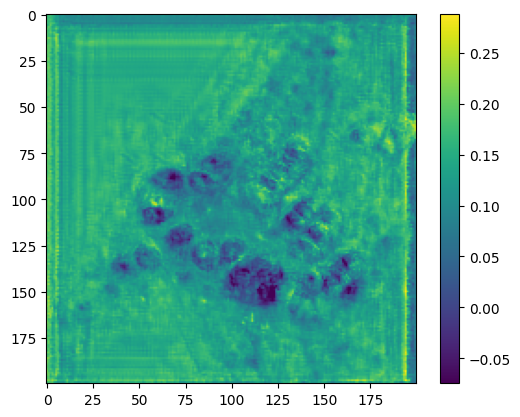

In [57]:
print(diffusion.rolling_stats_pts.mean, diffusion.rolling_stats_pts.var, diffusion.rolling_stats_pts.std)
y_ddpm_denormalized = diffusion.rolling_stats_pts.denormalize(y_ddpm)
plt.imshow(y_ddpm_denormalized.cpu().numpy()[0, 0], cmap='viridis')
plt.colorbar()

[   0  100  200  300  400  500  600  700  800  900 1000 1100 1200 1300
 1400 1500 1600 1700 1800 1900]


DDIM sampling loop timestep: 100%|██████████| 20/20 [00:01<00:00, 17.42it/s]


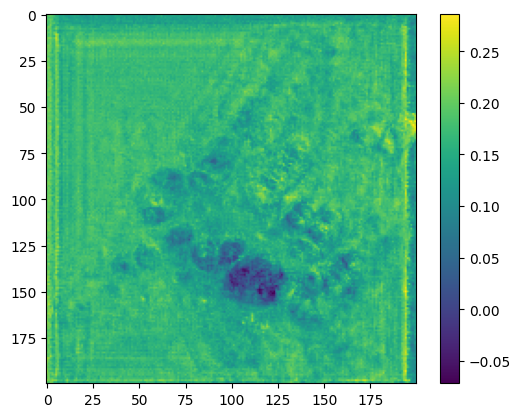

In [19]:
y_ddim, ret_arr_ddim = diffusion.ddim_sampler(y_cond=sample, noise=None, sample_inter=1, steps=20, clip_denoised=True, eta=0.9)
plt.imshow(diffusion.rolling_stats_pts.denormalize(y_ddim).cpu().numpy()[0, 0], cmap='viridis')
plt.colorbar()

In [63]:
print(diffusion.gammas)

tensor([9.9990e-01, 9.9979e-01, 9.9967e-01,  ..., 1.6960e-09, 1.6621e-09,
        1.6288e-09], device='cuda:0')


DPM-Solver++(2M) sampler: 100%|██████████| 100/100 [00:04<00:00, 20.14it/s]


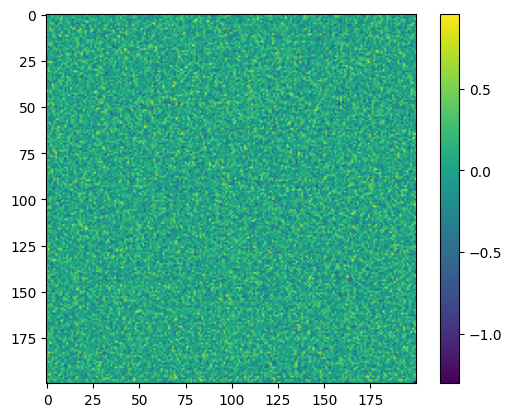

In [12]:
y_dpm_solvr, ret_dpm_solver = diffusion.dpm_solver_multi_step_sampler(y_cond=sample, noise=None, sample_inter=1, steps=100, clip_denoised=True)
plt.imshow(y_dpm_solvr.cpu().numpy()[0, 0], cmap='viridis')
plt.colorbar()

DPM-Solver++(2M) sampler: 100%|██████████| 90/90 [00:05<00:00, 16.95it/s]


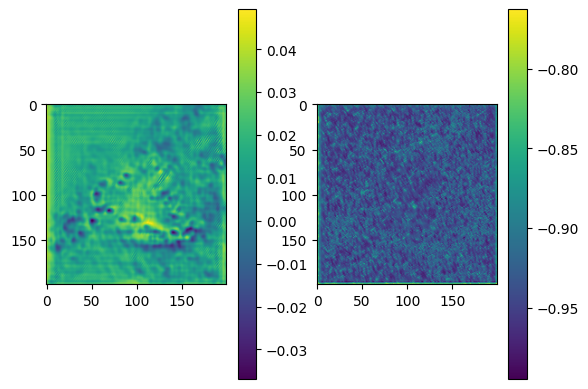

In [ ]:
sample = single_loader.dataset[0]['img_bev_embed'].to('cuda')
# print(sample.shape)
diffusion.set_new_noise_schedule(phase='test')
# y_ddpm, ret_ddpm = diffusion.ddpm_sampler(y_cond=sample.unsqueeze(0), noise=noise, clip_denoised=True)
y_ddim, ret_ddim = diffusion.dpm_solver_multi_step_sampler(y_cond=sample.unsqueeze(0), sample_inter=1, steps=90, clip_denoised=True)

fig, ax = plt.subplots(1, 2)

im0 = ax[0].imshow(y_ddpm.cpu().numpy()[0, 0], cmap='viridis')
im1 = ax[1].imshow(y_ddim.cpu().numpy()[0, 0], cmap='viridis')

fig.colorbar(im0, ax=ax[0])
fig.colorbar(im1, ax=ax[1])

plt.show()

In [ ]:
fig, ax = plt.subplots(1, 2)

im0 = ax[0].imshow(y_ddpm.cpu().numpy()[0, 0], cmap='viridis')
im1 = ax[1].imshow(y_ddim.cpu().numpy()[0, 0], cmap='viridis')

fig.colorbar(im0, ax=ax[0])
fig.colorbar(im1, ax=ax[1])

plt.show()

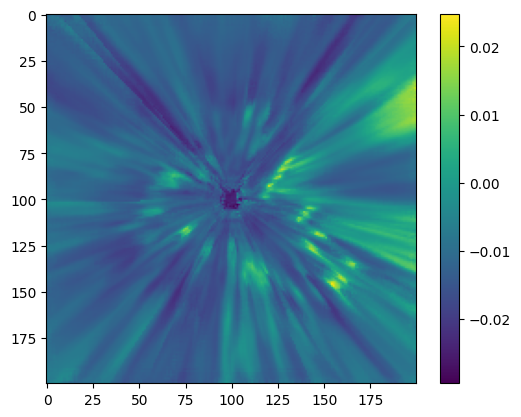

In [42]:
sample_img = single_loader.dataset[0]['img_bev_embed'].to('cuda')
plt.imshow(sample_img.cpu().squeeze(0).numpy(), cmap='viridis')
plt.colorbar()

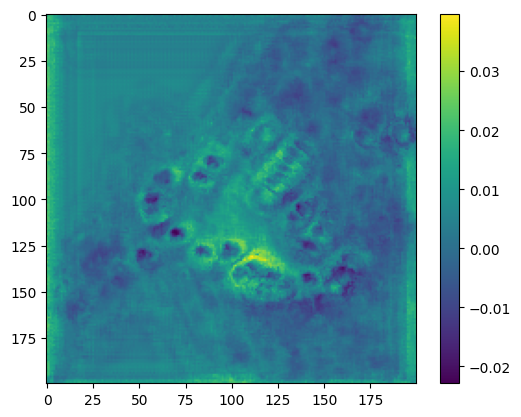

In [43]:
sample_pts = single_loader.dataset[0]['pts_bev_embed'].to('cuda')
plt.imshow(sample_pts.cpu().squeeze(0).numpy(), cmap='viridis')
plt.colorbar()
plt.show()

In [61]:
print(ret_ddim.shape)

torch.Size([1, 1, 200, 200])


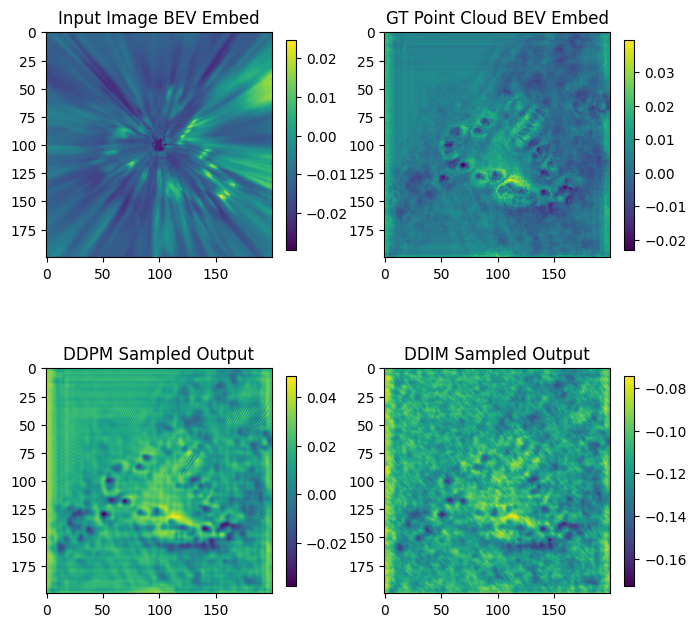

In [57]:
fig, ax = plt.subplots(2, 2, figsize=(8, 8))

im0 = ax[0,0].imshow(sample_img.cpu().squeeze(0).numpy(), cmap='viridis')
ax[0,0].set_title('Input Image BEV Embed')
im1 = ax[0,1].imshow(sample_pts.cpu().squeeze(0).numpy(), cmap='viridis')
ax[0,1].set_title('GT Point Cloud BEV Embed')

im2 = ax[1,0].imshow(y_ddpm.cpu().numpy()[0, 0], cmap='viridis')
ax[1,0].set_title('DDPM Sampled Output')
im3 = ax[1,1].imshow(y_ddim.cpu().numpy()[0, 0], cmap='viridis')
ax[1,1].set_title('DDIM Sampled Output')


fig.colorbar(im0, ax=ax[0,0], shrink=0.75)
fig.colorbar(im1, ax=ax[0,1], shrink=0.75)
fig.colorbar(im2, ax=ax[1,0], shrink=0.75)
fig.colorbar(im3, ax=ax[1,1], shrink=0.75)
plt.show()

In [60]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.animation as animation
import os

fig, ax = plt.subplots(2, 2, figsize=(8, 8))
im0 = ax[0,0].imshow(sample_img.cpu().squeeze(0).numpy(), cmap='viridis')
ax[0,0].set_title('Input Image BEV Embed')
im1 = ax[0,1].imshow(sample_pts.cpu().squeeze(0).numpy(), cmap='viridis')
ax[0,1].set_title('GT Point Cloud BEV Embed')
fig.colorbar(im0, ax=ax[0,0], shrink=0.75)
fig.colorbar(im1, ax=ax[0,1], shrink=0.75)

writer = animation.FFMpegWriter(fps=10)
ims = []

for i in range(ret_ddpm.shape[0]):

    im2 = ax[1,0].imshow(ret_ddpm[i].cpu().numpy()[0], cmap='viridis')
    ax[1,0].set_title('DDPM Sampled Output')
    if i < ret_ddim.shape[0]:
        im3 = ax[1,1].imshow(ret_ddim[i].cpu().numpy()[0], cmap='viridis')
        ax[1,1].set_title('DDIM Sampled Output')
    else:
        im3 = ax[1,1].imshow(y_ddim.cpu().numpy()[0,0], cmap='viridis')
        ax[1,1].set_title('DDIM Sampled Output')

    ims.append([im2, im3])

fig.colorbar(im2, ax=ax[1,0], shrink=0.75)
fig.colorbar(im3, ax=ax[1,1], shrink=0.75)
ani = animation.ArtistAnimation(fig, ims, interval=10, blit=True, repeat_delay=1000)
ani.save('diffusion_process_comparison.mp4', writer=writer)
plt.close()